In [42]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import re
from datetime import date
import copy

In [43]:
import scipy.stats as stats

import statsmodels.api as sm
import statsmodels.stats.multicomp

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import scikit_posthocs as sp

In [44]:
save = False

In [45]:
import warnings; warnings.simplefilter('ignore')

In [46]:
working_dir = "/om2/user/ckauf/.result_caching/neural_nlp.score"

In [47]:
categories_perturb_loss = ['original',
                           'nouns',
                           'nounsverbs',
                           'nounsverbsadj',
                           'contentwords',
                           'random-nouns',
                           'functionwords']

categories_perturb_meaning = ['sentenceshuffle_passage',
                              'sentenceshuffle_topic',
                              'sentenceshuffle_random']

categories_scrambled = ['original',
                        'scrambled1',
                        'scrambled3',
                        'scrambled5',
                        'scrambled7',
                        'lowpmi',
                        'lowpmi-random',
                        'backward',
                        'random-wl',
                        'random-wl-samepos']

categories_perturb = categories_perturb_loss + categories_perturb_meaning

categories = [categories_perturb, categories_scrambled]
keys = ["perturb", "scrambled"]

categories_dict = dict(zip(keys, categories))

In [48]:
categories_dict

{'perturb': ['original',
  'nouns',
  'nounsverbs',
  'nounsverbsadj',
  'contentwords',
  'random-nouns',
  'functionwords',
  'sentenceshuffle_passage',
  'sentenceshuffle_topic',
  'sentenceshuffle_random'],
 'scrambled': ['original',
  'scrambled1',
  'scrambled3',
  'scrambled5',
  'scrambled7',
  'lowpmi',
  'lowpmi-random',
  'backward',
  'random-wl',
  'random-wl-samepos']}

In [49]:
def get_all_layers(model_identifier):
    """
    input: model_identifier of model of which we want to find the layers
    output: np.array of all unique layer identifiers, ordered by position
    """
    for ind,filename in enumerate(os.listdir(working_dir)):
        if "model=" + model_identifier in filename:
            file = os.path.join(working_dir,filename)
            with open(file, 'rb') as f:
                result = pickle.load(f)
            result = result['data']
            layer_list = np.unique(result.layer)
            #print(layer_list)
            #order double-digit layers at end of list
            double_digits = []
            if model_identifier in ['gpt2','distilgpt2']:
                double_digits = [elm for elm in layer_list if 'encoder.h.' in elm and len(elm.split('.h.')[-1]) > 1]
            if model_identifier == 'albert-xxlarge-v2':
                double_digits = [elm for elm in layer_list if 'encoder.albert_layer_groups.' in elm and len(elm.split('.albert_layer_groups.')[-1]) > 1]
            if model_identifier == 'xlnet-large-cased':
                double_digits = [elm for elm in layer_list if 'encoder.layer.' in elm and len(elm.split('.layer.')[-1]) > 1]
            if model_identifier == 'bert-large-uncased-whole-word-masking':
                double_digits = [elm for elm in layer_list if '.layer.' in elm and len(elm.split('.layer.')[-1].split('.')[0]) > 1]
            layers = [e for e in layer_list if e not in double_digits] + double_digits
            return layers
            break

In [50]:
def get_max_score(matrix):
    """
    input: result = out['data'].values matrix (e.g. for distilgpt2 a matrix of dimensions 7x2)
    output: maximum score and associated error for this matrix.
    """
    max_score, error = 0,0
    best_layernr = 0
    for i in range(len(matrix)):
        if matrix[i][0] > max_score:
            max_score = matrix[i][0]
            error = matrix[i][1]
            best_layernr = i
    return max_score, error, best_layernr

In [51]:
def get_best_scores_df(model_identifier, categories_dict,
                       emb_context="Passage", split_coord="Sentence",
                       scr_perturb=None, testonperturbed=False, sent_meaning=None):
    """
    input: model_identifier
    output: dictionary containing the last score and associated error per condition.
            structure of dictionary: condition --> {score --> max_score, error --> associated error}
    """
    conditions = []
    max_scores = []
    errors = []
    raw_scores = []
    subject_scores = []
    
    subdict = {}
    
    layers = get_all_layers(model_identifier)
    #print(layers)
    
    use_categories_dict = copy.deepcopy(categories_dict)
    
    if testonperturbed:
        teston = "teston:"
        values = use_categories_dict[scr_perturb]
        new_values = [f"teston:{elm}" for elm in values]
        new_values = [re.sub("scrambled","scr",elm) for elm in new_values]
        use_categories_dict.update({scr_perturb : new_values})
    else:
        teston = ""
    
    for filename in os.listdir(working_dir):
        if os.path.isdir(os.path.join(working_dir,filename)):
            continue
                
        if not f"emb_context={emb_context},split_coord={split_coord}" in filename:
            continue 
            
        if (scr_perturb == "perturb") and not sent_meaning:
            if "sentenceshuffle" in filename:
                continue
        elif (scr_perturb == "perturb") and sent_meaning:
            if not any(x in filename for x in ["sentenceshuffle",f"-encoding-scrambled-{teston}original"]):
                continue
        else:
            pass
        
        if not testonperturbed:
            if "teston:" in filename:
                continue
        else:
            if not "teston:" in filename:
                continue
            
        model_name = filename.split(",")[1]
        
        if "model=" + model_identifier == model_name:
            if any(x in filename for x in [f"-encoding-{scr_perturb}", "-encoding-teston",
                                           f"-encoding-scrambled-{teston}original"]):
                condition = filename.split(",")[0].split("Pereira2018-encoding-")[-1]
                
                if scr_perturb == "perturb":
                    condition = re.sub("perturb-","",condition)
                    condition = re.sub("scrambled-","",condition)
                    
                elif scr_perturb == "scrambled":
                    if not any(x in condition for x in ["1", "3", "5", "7"]):
                        condition = re.sub("scrambled-","",condition)
                    else:
                        condition = condition
                
                if condition not in use_categories_dict[scr_perturb]:
                    continue
                print(condition)
                
                file = os.path.join(working_dir,filename)
                with open(file, 'rb') as f:
                    out = pickle.load(f)
                result_all = out['data']
                result = out['data'].values
                
                max_score, error, best_layernr = get_max_score(result)
                best_layer = layers[best_layernr]

                # Package for stats
#                 final_layer = layers[-1] #shouldn't this be best layer? *****QUESTION CK*****
                #print(final_layer)

                raw_score = result_all.raw.raw #unnormalized, ungrouped data *****QUESTION CK*****
                final_layer_raw = raw_score[{"layer": [layer == best_layer for layer in raw_score["layer"]]}]
    #           raw_scores.append(final_layer_raw) # if saving all
#                 final_layer_raw = final_layer_raw.fillna(0)
                raw_scores.append(final_layer_raw.values)

                subject_score = final_layer_raw.groupby('subject').median().values #is this correct? 
                subject_scores.append(subject_score)

                # append to dict
                subdict[condition] = subject_score

                #print(result, '\n\n')
#                 max_score, error = get_max_score(result)

                conditions.append(condition)
                max_scores.append(max_score)
                errors.append(error/1.48) #TODO TAKE OUT *****QUESTION CK*****
            
    index = conditions
    df = pd.DataFrame({'score': max_scores, 'error': errors, 'condition':conditions})
    df['condition'] = pd.Categorical(df['condition'], categories=use_categories_dict[scr_perturb])
    scores_df = df.sort_values(by='condition')
    
    # Currently not outputted
    df_stats = pd.DataFrame({'score': raw_scores}, index=conditions)
    df_substats = pd.DataFrame({'score': subject_scores}, index=conditions)
    
    # Transform subdict to statsmodel api form:
    x = subdict.copy()
    subdf = pd.DataFrame(x)
    subdf = subdf.melt(var_name='groups', value_name='values')
    
    subdf['groups'] = pd.Categorical(subdf['groups'], categories=use_categories_dict[scr_perturb], ordered=True)
    subdf = subdf.sort_values('groups')
    
    return scores_df, subdict, subdf

In [52]:
def anova_ttest(model_identifier, categories_dict, emb_context="Passage", split_coord="Sentence",
                scr_perturb=None, testonperturbed=False, sent_meaning=None):
    
    scores, subdict, subdf = get_best_scores_df(model_identifier=model_identifier, categories_dict=categories_dict,
                                                emb_context=emb_context, split_coord=split_coord, 
                                                scr_perturb=scr_perturb, testonperturbed=testonperturbed,
                                                sent_meaning=sent_meaning)

    # abbreviate condition names for perturb
    curr_groups = list(subdf["groups"])
    new_groups = []
    for elm in curr_groups:
        if "sentenceshuffle_random" in elm:
            elm = re.sub("sentenceshuffle_random","sent_random",elm)
        if elm == "sentenceshuffle_passage":
            elm = re.sub("sentenceshuffle_passage","sent_passage",elm)
        if elm == "sentenceshuffle_topic":
            elm = re.sub("sentenceshuffle_topic","sent_topic",elm)
        new_groups.append(elm)
    subdf["new_groups"] = new_groups
    
    ttest = sp.posthoc_ttest(subdf, val_col='values', group_col='new_groups', p_adjust='fdr_bh')
    plt.figure(figsize=(7,7))
    sp.sign_plot(ttest, annot=ttest, fmt='.3f', **heatmap_args)
    
    if len(model_identifier.split("-")) == 1:
        model_identifier += "-lasttoken"
    plt.title('{}'.format(model_identifier),fontsize=18)
    plt.subplots_adjust(top=0.8) 
    
    if not os.path.isdir("fig"):
        os.mkdir("fig")
    if save:
        savename = f'fig/stats-match-to-brain_{scr_perturb}_{model_identifier}.png'
        plt.savefig(savename, bbox_inches='tight', dpi=240)
    plt.show()

    return ttest

In [53]:
# Plot arguments
#args = {'annot':ttest}
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.95, 0.55, 0.04, 0.3]}

# Decontextualized

backward
lowpmi
lowpmi-random
original
random-wl
scrambled1
scrambled3
scrambled5
scrambled7


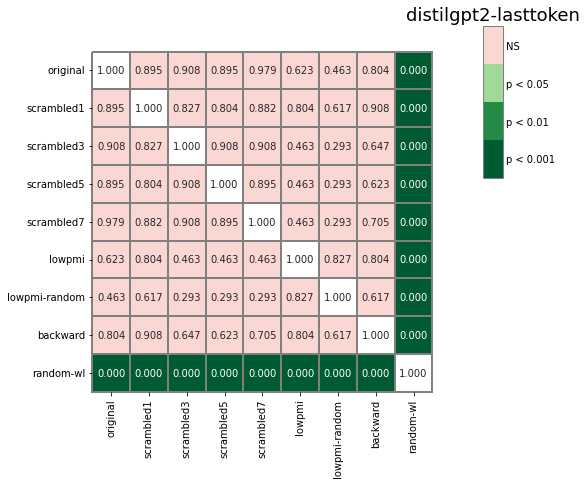

In [54]:
g=anova_ttest('distilgpt2',categories_dict,scr_perturb="scrambled", emb_context="Sentence")

contentwords
functionwords
nouns
nounsverbs
nounsverbsadj
original


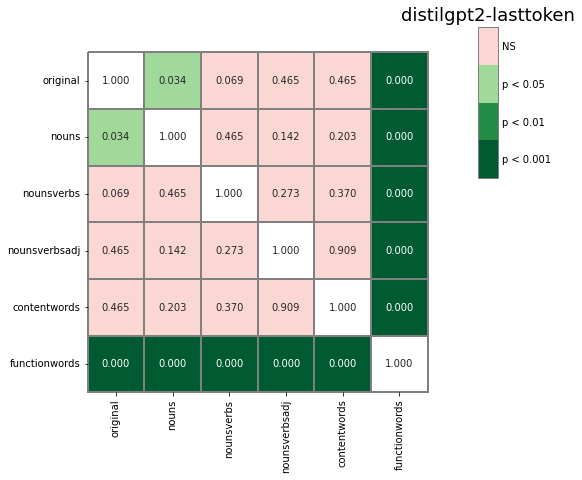

In [55]:
g=anova_ttest('distilgpt2',categories_dict,scr_perturb="perturb", emb_context="Sentence")

sentenceshuffle_passage
sentenceshuffle_random
sentenceshuffle_topic
original


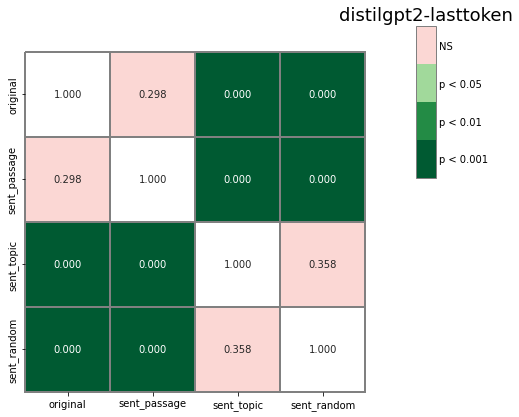

In [56]:
g=anova_ttest('distilgpt2',categories_dict,scr_perturb="perturb", emb_context="Sentence",sent_meaning=True)

# Normal

backward
lowpmi
lowpmi-random
original
random-wl
scrambled1
scrambled3
scrambled5
scrambled7


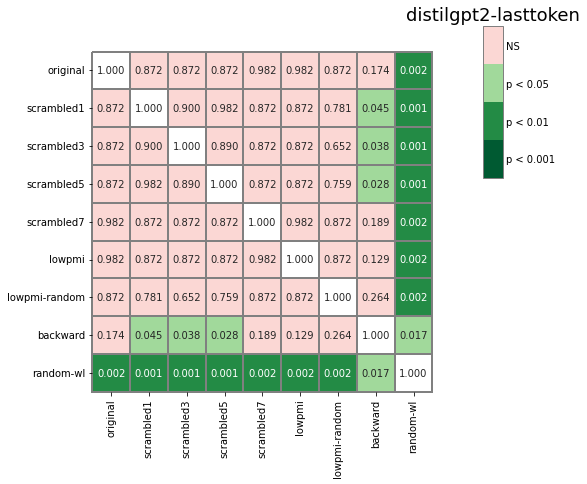

In [57]:
g=anova_ttest('distilgpt2',categories_dict,scr_perturb="scrambled")

sentenceshuffle_passage
sentenceshuffle_random
sentenceshuffle_topic
original


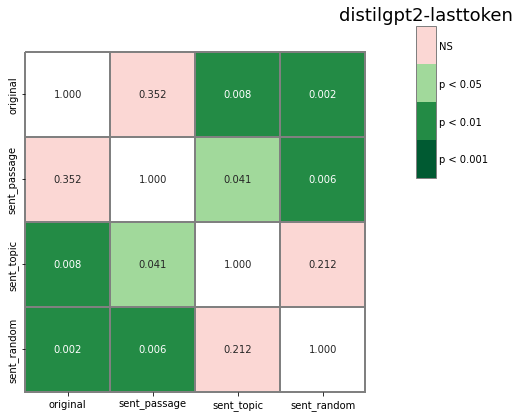

In [58]:
g=anova_ttest('distilgpt2',categories_dict,scr_perturb="perturb", sent_meaning=True)

In [59]:
# g=anova_ttest('gpt2',categories_dict,scr_perturb="perturb", sent_meaning=True)

backward
lowpmi
lowpmi-random
original
random-wl
scrambled1
scrambled3
scrambled5
scrambled7


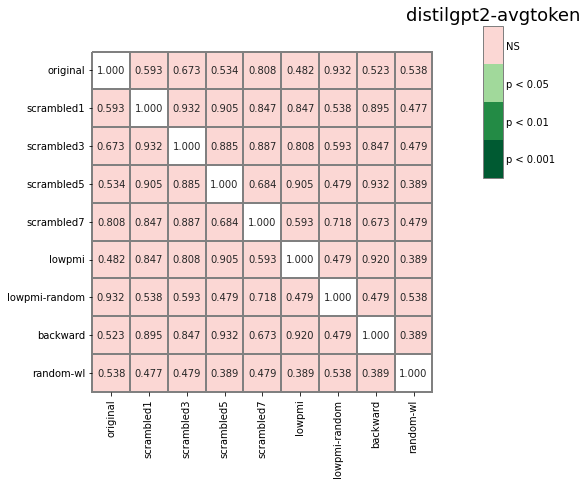

In [60]:
g=anova_ttest('distilgpt2-avgtoken',categories_dict,scr_perturb="scrambled")

contentwords
functionwords
nouns
nounsverbs
nounsverbsadj
random-nouns
original


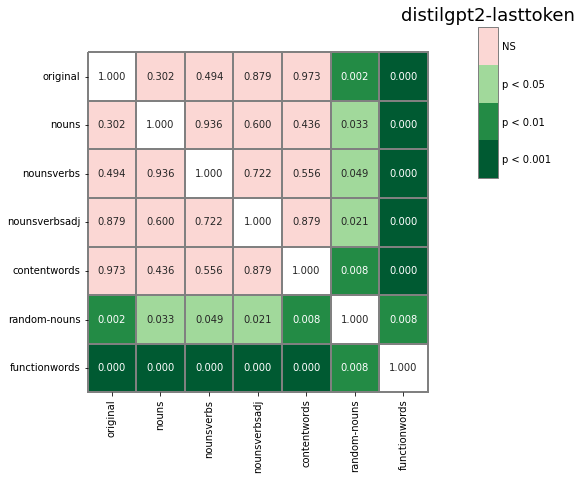

In [61]:
g=anova_ttest('distilgpt2',categories_dict,scr_perturb="perturb")

contentwords
functionwords
nouns
nounsverbs
nounsverbsadj
original


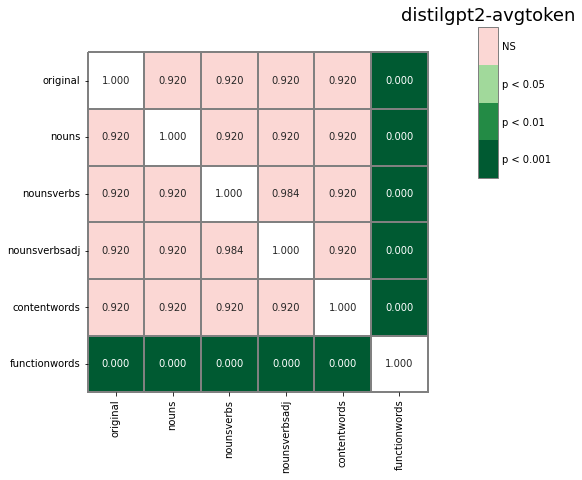

In [62]:
g=anova_ttest('distilgpt2-avgtoken',categories_dict,scr_perturb="perturb")

sentenceshuffle_passage
sentenceshuffle_random
sentenceshuffle_topic
original


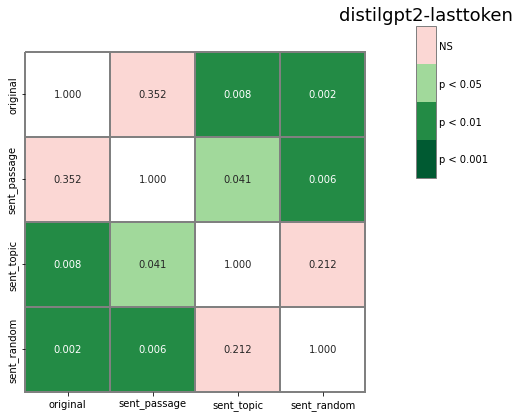

In [63]:
g=anova_ttest('distilgpt2',categories_dict,scr_perturb="perturb", sent_meaning=True)

sentenceshuffle_passage
sentenceshuffle_random
sentenceshuffle_topic
original


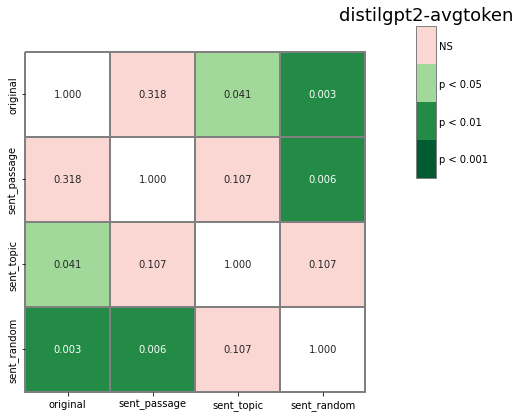

In [64]:
g=anova_ttest('distilgpt2-avgtoken',categories_dict,scr_perturb="perturb", sent_meaning=True)

backward
lowpmi
lowpmi-random
original
random-wl
scrambled1
scrambled3
scrambled5
scrambled7


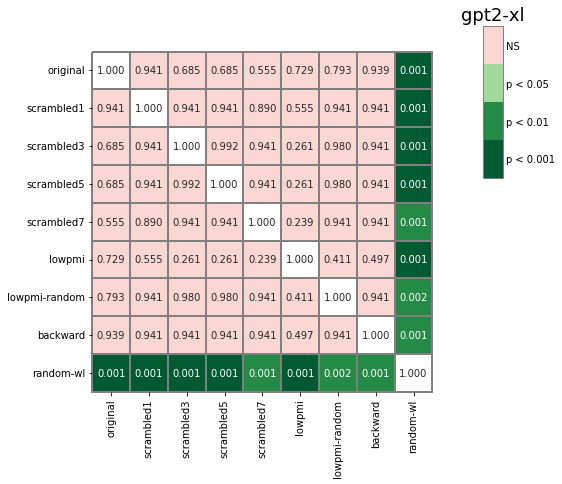

In [65]:
g=anova_ttest('gpt2-xl',categories_dict,scr_perturb="scrambled")

contentwords
nouns
nounsverbs
nounsverbsadj
original


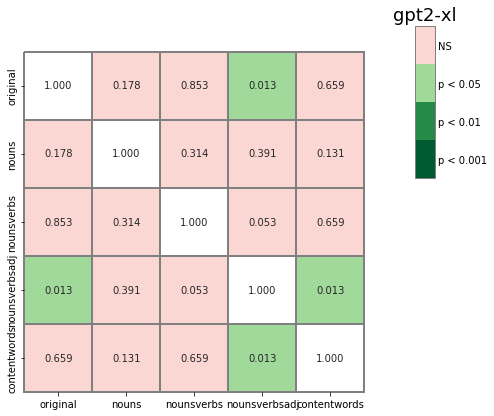

In [66]:
g=anova_ttest('gpt2-xl',categories_dict,scr_perturb="perturb")

sentenceshuffle_passage
sentenceshuffle_random
sentenceshuffle_topic
original


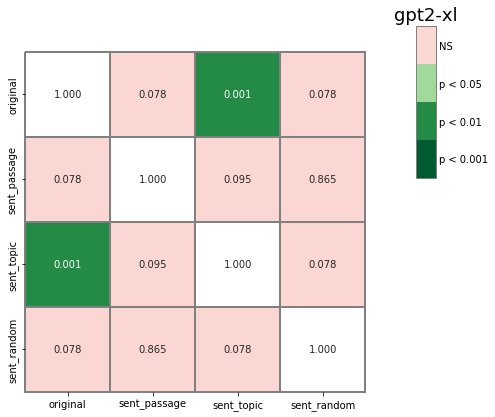

In [67]:
g=anova_ttest('gpt2-xl',categories_dict,scr_perturb="perturb", sent_meaning=True)

# Test on perturbed

teston:backward
teston:lowpmi
teston:lowpmi-random
teston:original
teston:random-wl
teston:scr1
teston:scr3
teston:scr5
teston:scr7


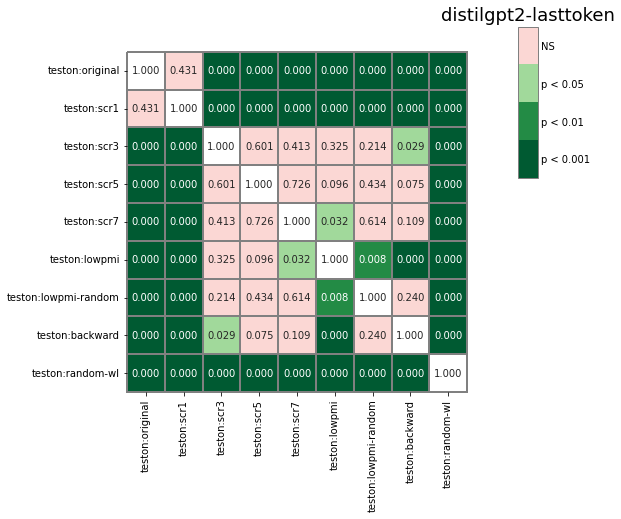

In [68]:
g=anova_ttest('distilgpt2',categories_dict,scr_perturb="scrambled", testonperturbed=True)

teston:contentwords
teston:functionwords
teston:nouns
teston:nounsverbs
teston:nounsverbsadj
teston:original
teston:random-nouns


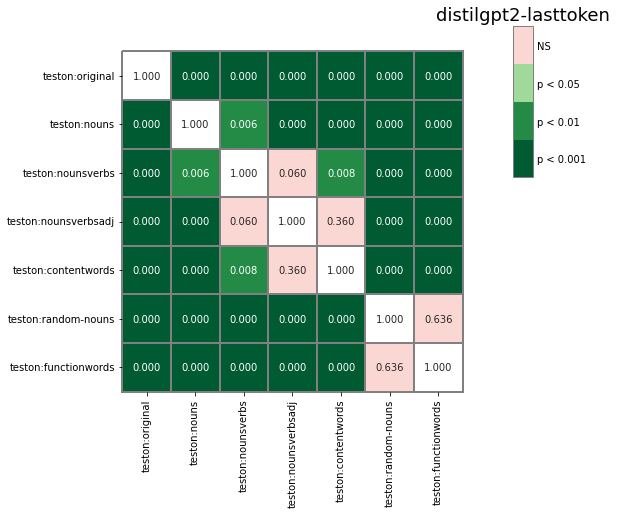

In [69]:
g=anova_ttest('distilgpt2',categories_dict,scr_perturb="perturb", testonperturbed=True)

teston:backward
teston:lowpmi
teston:lowpmi-random
teston:original
teston:random-wl
teston:scr1
teston:scr3
teston:scr5
teston:scr7


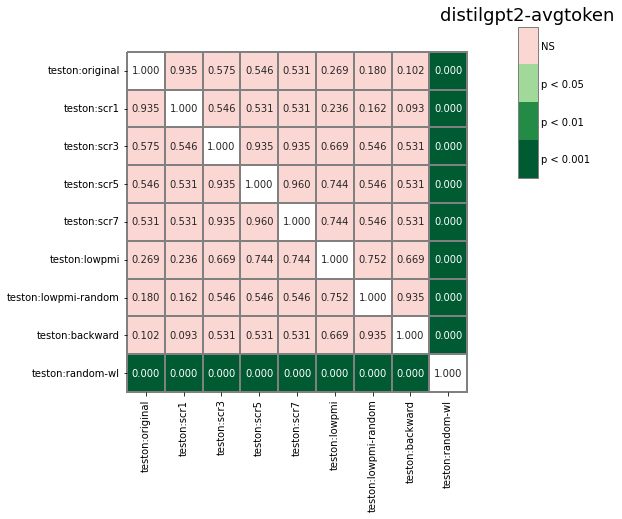

In [70]:
g=anova_ttest('distilgpt2-avgtoken',categories_dict,scr_perturb="scrambled", testonperturbed=True)

teston:contentwords
teston:functionwords
teston:nouns
teston:nounsverbs
teston:nounsverbsadj
teston:original


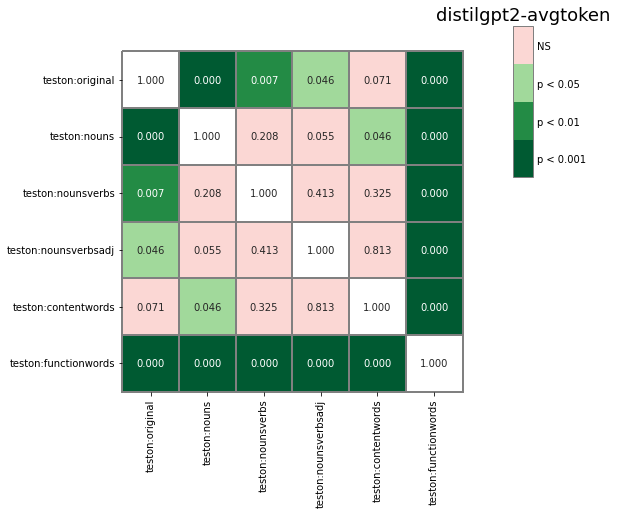

In [71]:
g=anova_ttest('distilgpt2-avgtoken',categories_dict,scr_perturb="perturb", testonperturbed=True)

# Passagesplit

backward
lowpmi
lowpmi-random
original
random-wl
scrambled1
scrambled3
scrambled5
scrambled7


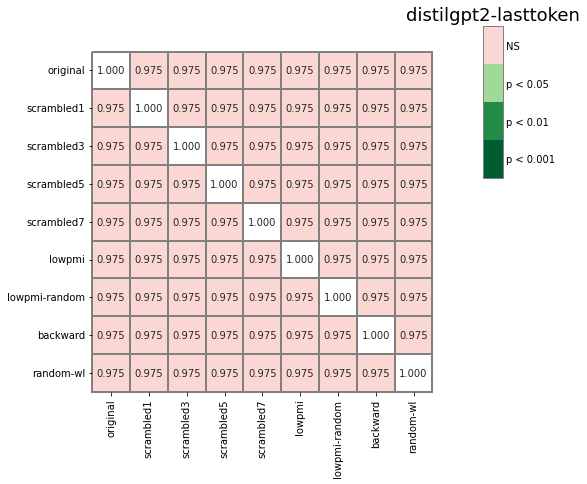

In [72]:
g=anova_ttest('distilgpt2',categories_dict,scr_perturb="scrambled", split_coord="Passage")

contentwords
functionwords
nouns
nounsverbs
nounsverbsadj
original


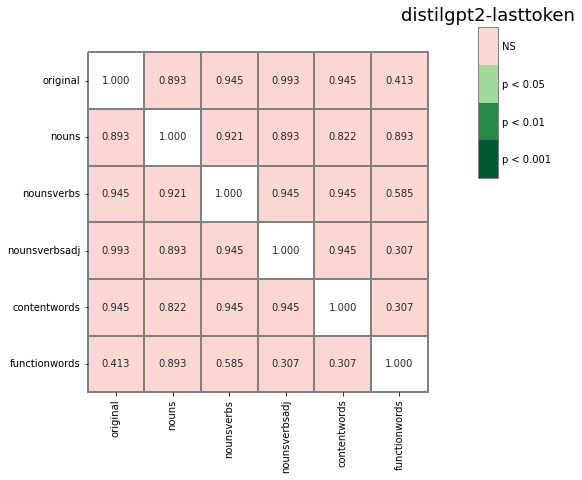

In [73]:
g=anova_ttest('distilgpt2',categories_dict,scr_perturb="perturb", split_coord="Passage")

sentenceshuffle_passage
sentenceshuffle_random
sentenceshuffle_topic
original


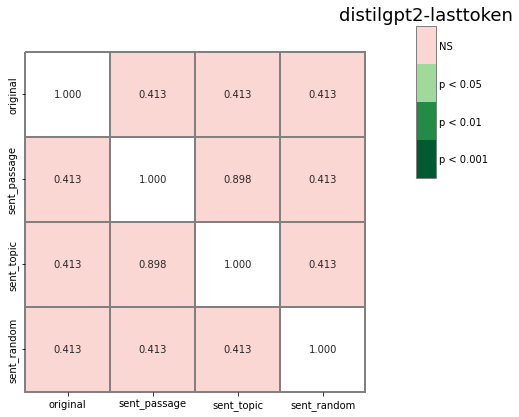

In [74]:
g=anova_ttest('distilgpt2',categories_dict,scr_perturb="perturb", split_coord="Passage", sent_meaning=True)

backward
lowpmi
lowpmi-random
original
random-wl
scrambled1
scrambled3
scrambled5
scrambled7


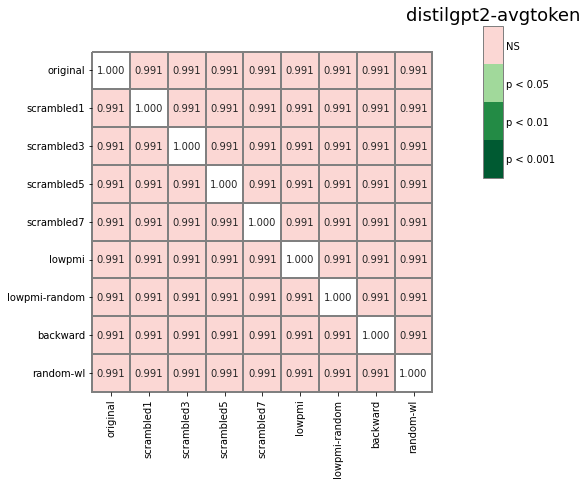

In [75]:
g=anova_ttest('distilgpt2-avgtoken',categories_dict,scr_perturb="scrambled", split_coord="Passage")

contentwords
functionwords
nouns
nounsverbs
nounsverbsadj
original


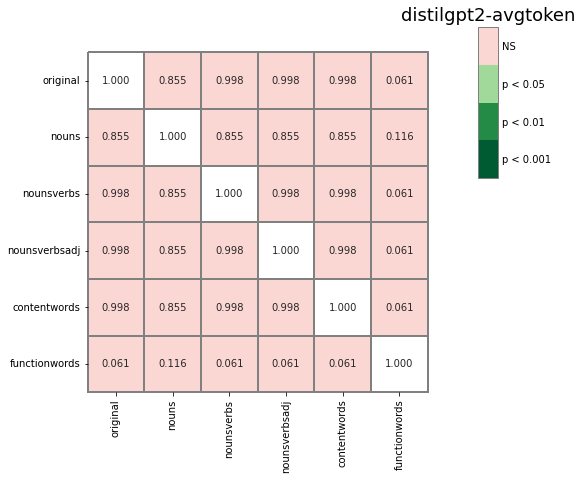

In [76]:
g=anova_ttest('distilgpt2-avgtoken',categories_dict,scr_perturb="perturb", split_coord="Passage")

In [77]:
# g=anova_ttest('distilgpt2-avgtoken',categories_dict,scr_perturb="scrambled", split_coord="Passage")

In [78]:
# g=anova_ttest('gpt2',categories_dict,scr_perturb="scrambled")

# Loop into subplots

In [79]:
import math
from matplotlib.gridspec import GridSpec

def get_stats_loop(model_list,scr_perturb=None, sent_meaning=True):
    nsubplots = len(model_list)
    nrows = math.ceil(nsubplots/2)
    
    #fig2 = plt.figure(constrained_layout=True, figsize=(12, 5.5*nrows))
    fig2 = plt.figure(constrained_layout=True, figsize=(18, 8*nrows))
    #fig2 = plt.figure(figsize=(20, 10*nrows))
    fig2.suptitle(f'Post-hoc ANOVA pairwise t-tests | {scr_perturb}', fontsize=22, y=1.05)
    spec2 = GridSpec(ncols=2, nrows=nrows, figure=fig2)
    f2_ax = []
    
    model_counter = 0
    for i in range(nrows):
        for j in range(2):
            if model_counter + 1 > nsubplots:
                break
            else:
                f2_ax.append(fig2.add_subplot(spec2[i, j]))
                scores, subdict, subdf = get_best_scores_df(model_list[model_counter],categories_dict,scr_perturb=scr_perturb,
                                                           sent_meaning=sent_meaning)
    
#                 if scr_perturb == "scrambled":
#                     F, p = stats.f_oneway(subdict['original'], subdict['scrambled1'],
#                      subdict['scrambled3'], subdict['scrambled5'],
#                      subdict['scrambled7'], subdict['lowpmi'],
#                      subdict['lowpmi-random'], subdict['backward'],
#                      subdict['random-wl'], subdict['random-wl-samepos'])

#                 elif scr_perturb == "perturb":
#                     F, p = stats.f_oneway(subdict['original'],
#                     subdict['nouns'],subdict['random-nouns'],
#                     subdict['nounsverbs'], subdict['nounsverbsadj'],
#                     subdict['contentwords'], subdict['functionwords'],
#                     subdict['sentenceshuffle_random'], subdict['sentenceshuffle_random-topic-criteria'],
#                     subdict['sentenceshuffle_random-topic-length-criteria'], 
#                     subdict['sentenceshuffle_passage'], subdict['sentenceshuffle_topic'])


                # abbreviate condition names for perturb
                curr_groups = list(subdf["groups"])
                new_groups = []
                for elm in curr_groups:
                    if "sentenceshuffle_random" in elm:
                        elm = re.sub("sentenceshuffle_random","sent_random",elm)
                    if "topic-length-criteria" in elm:
                        elm = re.sub("topic-length-criteria","diffT-sameL",elm)
                    elif "topic-criteria" in elm:
                        elm = re.sub("topic-criteria","diffT",elm)
                    if elm == "sentenceshuffle_passage":
                        elm = re.sub("sentenceshuffle_passage","sent_passage",elm)
                    if elm == "sentenceshuffle_topic":
                        elm = re.sub("sentenceshuffle_topic","sent_topic",elm)
                    new_groups.append(elm)
                subdf["new_groups"] = new_groups
    
                ttest = sp.posthoc_ttest(subdf, val_col='values', group_col='new_groups')#, p_adjust='fdr_bh')
                #f2_ax[-1].figure(figsize=(6,6))
                sp.sign_plot(ttest, annot=ttest, fmt='.3f', **heatmap_args)
                model_name = model_list[model_counter]
                if not "avgtoken" in model_name:
                    model_name += "-lasttoken"
                f2_ax[-1].set_title(f'{model_name}',fontsize=18, pad=15)
                model_counter += 1
    if save:
        fig2.savefig(f'fig/stats-match-to-brain_loop_{scr_perturb}.png', bbox_inches='tight')

sentenceshuffle_passage
sentenceshuffle_random
sentenceshuffle_topic
original
sentenceshuffle_passage
sentenceshuffle_random
sentenceshuffle_topic
original
sentenceshuffle_passage
sentenceshuffle_random
sentenceshuffle_topic
original
sentenceshuffle_passage
sentenceshuffle_random
sentenceshuffle_topic
original


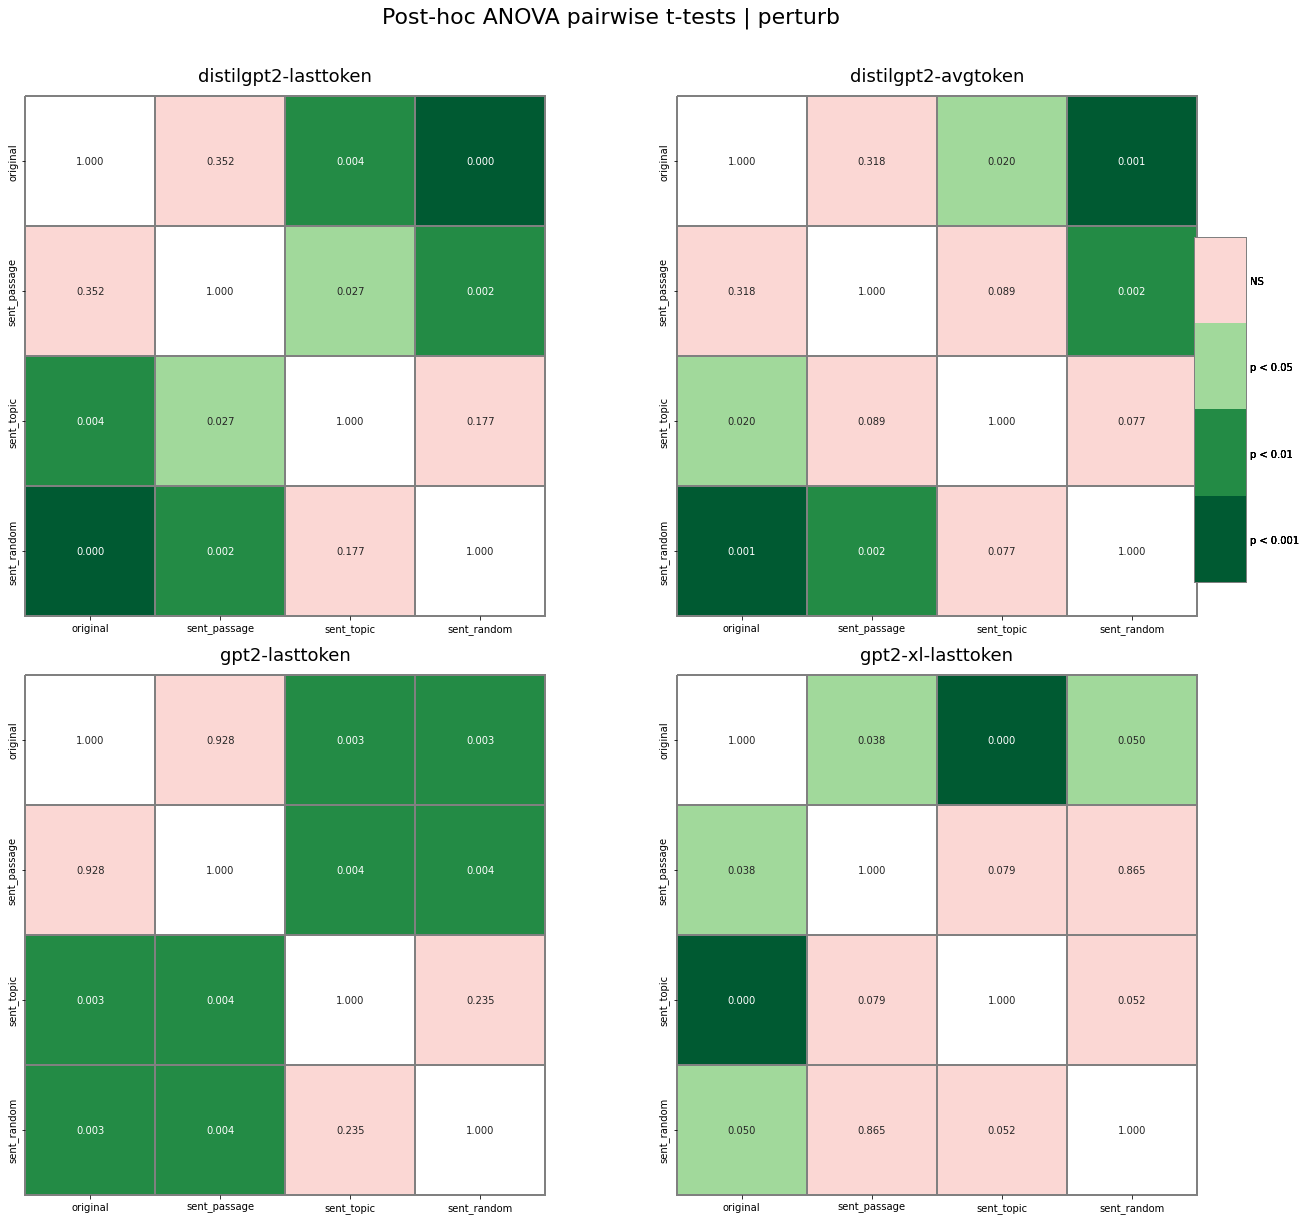

In [80]:
get_stats_loop(["distilgpt2", "distilgpt2-avgtoken", "gpt2", "gpt2-xl"], scr_perturb="perturb")

sentenceshuffle_passage
sentenceshuffle_random
sentenceshuffle_topic
original
sentenceshuffle_passage
sentenceshuffle_random
sentenceshuffle_topic
original
sentenceshuffle_passage
sentenceshuffle_random
sentenceshuffle_topic
original
sentenceshuffle_passage
sentenceshuffle_random
sentenceshuffle_topic
original


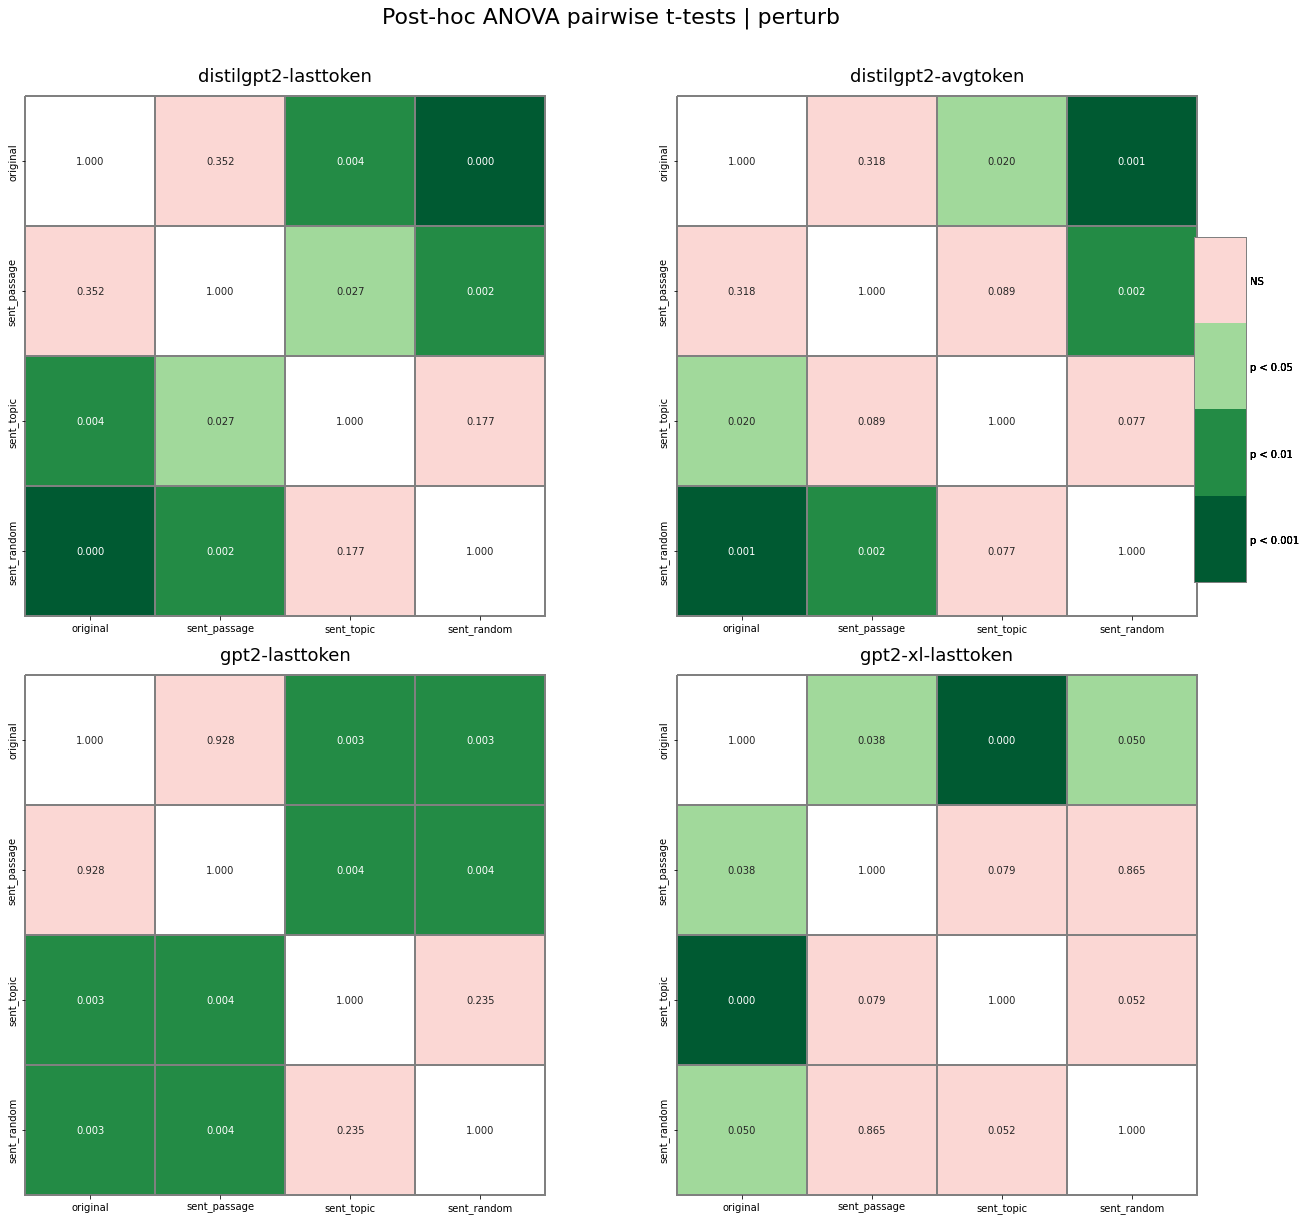

In [81]:
get_stats_loop(["distilgpt2", "distilgpt2-avgtoken", "gpt2", "gpt2-xl"], scr_perturb="perturb", sent_meaning=True)

backward
lowpmi
lowpmi-random
original
random-wl
scrambled1
scrambled3
scrambled5
scrambled7
backward
lowpmi
lowpmi-random
original
random-wl
scrambled1
scrambled3
scrambled5
scrambled7
backward
lowpmi
lowpmi-random
original
random-wl
scrambled1
scrambled3
scrambled5
scrambled7
backward
lowpmi
lowpmi-random
original
random-wl
scrambled1
scrambled3
scrambled5
scrambled7


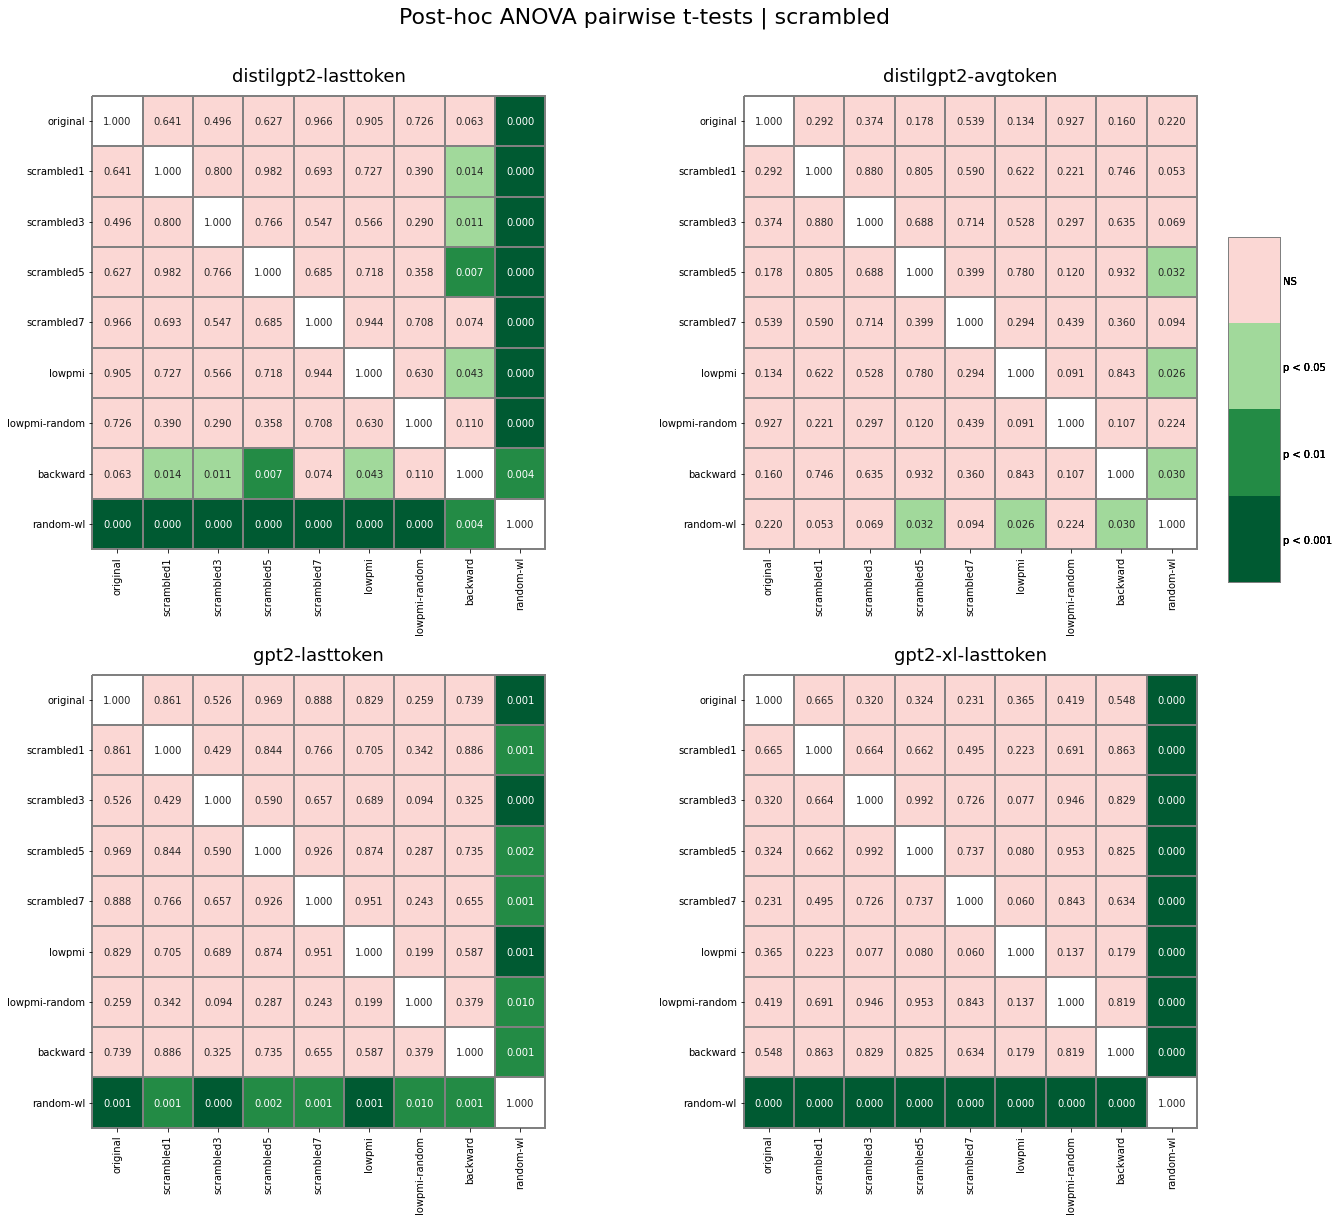

In [82]:
get_stats_loop(["distilgpt2", "distilgpt2-avgtoken", "gpt2", "gpt2-xl"], scr_perturb="scrambled")